In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA , PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import os
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.preprocessing import StandardScaler

In [2]:
def preprocess(directory):
    csv_files=[f for f in os.listdir(directory) if f.endswith('.csv')]
    all_data=[]
    for i in csv_files:
        df=pd.read_csv(os.path.join(directory, i))
        df.columns=['Output1','Output2','Output3','Output4','Output5','Output6','Output7','Output8']
        data=df.iloc[:, :4]
        all_data.append(data)
    my_data=pd.concat(all_data, ignore_index=True)

    return my_data

In [3]:
data=preprocess('datacollected')
data.head(10)

,Output1,Output2,Output3,Output4
0,466374,354159,1129594,977611
1,466498,354107,1129489,977535
2,466309,354043,1129338,977364
3,466128,354061,1129378,977371
4,466136,354082,1129409,977402
5,466370,354094,1129633,977617
6,466625,354010,1129853,977828
7,466428,353978,1129674,977638
8,466137,354054,1129426,977399
9,466142,354115,1129454,977431


In [4]:
start_markers = ['start one.png', 'start five.jpg', 'start nine.jpg', 'start six.jpg', 'start zero.png', 'start animal.jpg', 'start four.jpg', 'start eight.jpg', 'start three.jpg', 'start seven.jpg', 'start two.jpg']
end_markers = ['end one.png', 'end five.jpg', 'end nine.jpg', 'end six.jpg', 'end zero.png', 'end animal.jpg', 'end four.jpg', 'end eight.jpg', 'end three.jpg', 'end seven.jpg', 'end two.jpg']

In [5]:
def extract_center_rows(data, start_range, end_range, length):
    if start_range > end_range:
        raise ValueError("start_range should be less than or equal to end_range")

    if end_range - start_range < length:
        return False, 0

    range_data = data.loc[start_range:end_range]
    if length > len(range_data):
        raise ValueError("The specified length is greater than the number of rows in the range")

    center_index = len(range_data) // 2
    start_index = max(0, center_index - length // 2)
    end_index = start_index + length
    center_rows = range_data.iloc[start_index:end_index]

    return True, center_rows

In [6]:
def extract_data_between_markers(data, start_markers, end_markers, datashape):
    X = []
    Y = []
    between_markers = False
    label = None
    start_idx = None
    end_idx = None
    df_temp = []
    segment_lengths = []

    marker_to_label = {
        'start one.png': 1, 'end one.png': 1,
        'start two.jpg': 2, 'end two.jpg': 2,
        'start three.jpg': 3, 'end three.jpg': 3,
        'start four.jpg': 4, 'end four.jpg': 4,
        'start five.jpg': 5, 'end five.jpg': 5,
        'start six.jpg': 6, 'end six.jpg': 6,
        'start seven.jpg': 7, 'end seven.jpg': 7,
        'start eight.jpg': 8, 'end eight.jpg': 8,
        'start nine.jpg': 9, 'end nine.jpg': 9,
        'start zero.png': 0, 'end zero.png': 0,
        'start animal.jpg': -1, 'end animal.jpg': -1
    }

    for index, row in data.iterrows():
        if row.iloc[0] in start_markers:
            label = marker_to_label[row.iloc[0]]
            start_idx = index
            between_markers = True
            df_temp = []
            print(f"Start marker found at index {index}, label {label},{row.iloc[0]}")
        elif row.iloc[0] in end_markers:
            if between_markers and len(df_temp) > 0:
                end_idx = index
                success, extracted_data = extract_center_rows(data, start_idx, end_idx, datashape[0])
                if success:
                    X.append(extracted_data.values.astype(float))
                    Y.append(label)
                    print(f"End marker found at index {index}, segment length {len(df_temp)}")
                segment_lengths.append(len(df_temp))
            between_markers = False
        elif between_markers:
            df_temp.append(row.iloc[:4].values.tolist())

    X = np.array(X)
    X = X.reshape(X.shape[0], -1)
    Y = np.array(Y)

    print("Total segments found:", len(segment_lengths))
    print("Segment lengths:", segment_lengths)
    print("Number of segments meeting length requirement:", len(X))

    return X, Y

In [100]:
datashape = (1000, 4)

X, Y = extract_data_between_markers(data, start_markers, end_markers, datashape)


print("X shape:", X.shape)
print("Y shape:", Y.shape)

print("Unique labels in Y:", np.unique(Y))

Start marker found at index 2279, label 2,start two.jpg
End marker found at index 3584, segment length 1304
Start marker found at index 4225, label 3,start three.jpg
End marker found at index 5506, segment length 1280
Start marker found at index 6403, label -1,start animal.jpg
End marker found at index 7428, segment length 1024
Start marker found at index 8325, label 4,start four.jpg
End marker found at index 9606, segment length 1280
Start marker found at index 10247, label 6,start six.jpg
End marker found at index 11400, segment length 1152
Start marker found at index 12169, label 0,start zero.png
End marker found at index 13450, segment length 1280
Start marker found at index 14091, label 8,start eight.jpg
End marker found at index 15244, segment length 1152
Start marker found at index 15885, label 7,start seven.jpg
End marker found at index 17166, segment length 1280
Start marker found at index 17807, label 5,start five.jpg
End marker found at index 19088, segment length 1280
Start

In [101]:
Xa=X
Ya=Y


In [115]:
print(Y.shape)
Y=Ya
X=Xa

(155,)


In [116]:
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

In [117]:
ica = FastICA(random_state=42)
pca = PCA()
X_ica = ica.fit_transform(X_normalized)
X_pca = pca.fit_transform(X_normalized)
X_combined = np.hstack((X_ica, X_pca))

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


In [118]:
X_combined=np.array(X_combined)
Y=np.array(Y)
print(X_combined.shape)
print(Y.shape)

(194, 388)
(194,)


In [119]:
X_train, X_temp, y_train, y_temp = train_test_split(X_combined, Y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [120]:
#Data augmentaion using time slicing
y_aug = np.copy(y_train)
x_aug = np.copy(X_train)
X = np.array(X_train)
Y = np.array(y_train)
for i in range(-1, 10):
    new_data = []
    new_data_y = []
    X_filtered = X_train[Y == i]
    if len(X_filtered) < 4:
        continue
    new_data_point = []
    for j in range(50):
        random_indices = np.random.choice(len(X_filtered), size=4, replace=False)
        X_sampled = X_filtered[random_indices]
        X_sampled = np.array(X_sampled)
        new_data_point.append(np.concatenate((
            X_sampled[0][:1000],
            X_sampled[1][1000:2000],
            X_sampled[2][2000:3000],
            X_sampled[3][3000:4000]
        ), axis=0))
    new_data = np.array(new_data_point)
    new_data_y = [i] * len(new_data)
    y_aug = np.concatenate((y_aug, new_data_y), axis=0)
    x_aug = np.concatenate((x_aug, new_data), axis=0)
print(f"x_aug shape: {x_aug.shape}")
print(f"y_aug shape: {y_aug.shape}")


x_aug shape: (705, 388)
y_aug shape: (705,)


In [121]:
svm = SVC()

In [122]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': [ 'rbf'],
    'gamma': ['scale', 'auto']
}

grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(x_aug, y_aug)

# Best SVM model
best_svm = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters: {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}


In [123]:
rf = RandomForestClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)

In [124]:
ensemble = VotingClassifier(estimators=[('svm', best_svm), ('rf', rf), ('gb', gb)], voting='hard')
ensemble.fit(x_aug, y_aug)

VotingClassifier(estimators=[('svm', SVC(C=100, gamma='auto')),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('gb',
                              GradientBoostingClassifier(random_state=42))])

In [125]:
# Validate the model on the validation set
y_val_pred = ensemble.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

Validation Accuracy: 5.26%


In [126]:
y_pred = ensemble.predict(X_test)

In [127]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 10.00%


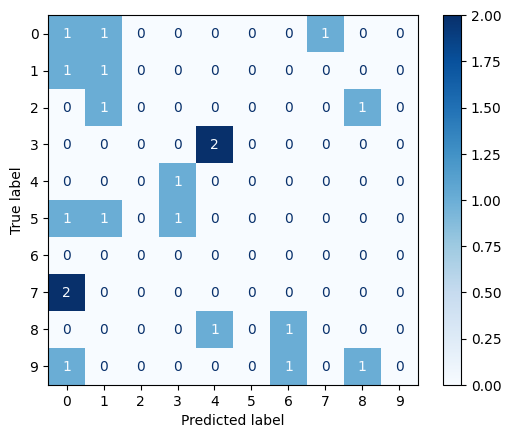

In [128]:
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.show()